In [11]:
import numpy as np
import torch

In [12]:
# import matplotlib
# matplotlib.use('Agg')

import matplotlib.pyplot as plt
SAVE_PLOTS = False

In [13]:
from utils import plot_spikes_in_time, print_and_plot_accuracy_metrics, plot_metrics
from scnn import SNN
from scnn.optim import RAdam

from data.data_augmentor import data_augment, batchify
from tools.time_expector import TimeExpector
from tools.notify import notify
time_expector = TimeExpector()

In [14]:
batch_size = 16
nb_epochs = 20
nb_frame = 40

# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
print("Device:", device)

Device: cuda


In [15]:
# FIXME
my_laptop = False
if my_laptop:
    CACHE_FOLDER_PATH = "/Users/aref/dvs-dataset/Cached"
    DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/DvsGesture"
else:
    CACHE_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"
    DATASET_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"

    
# def load_data(trail):
# #     if test_run:
# #         trail = 'acc_test' # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Remove this >>>>>>>>>>>>>>>>
    
#     if trail.startswith('acc'):
#         max_augmentation = 1
#         augmentation = False
#     else:
#         max_augmentation = 2 if trail == 'train' else 1
#         augmentation = True
    
#     trail = trail.replace('acc_', '')
#     return batchify(
#         trail,
#         DATASET_FOLDER_PATH,
#         CACHE_FOLDER_PATH,
#         condition_limit=['natural'],
#         batch_size=batch_size,
#         augmentation=augmentation,
#         max_augmentation=max_augmentation,
#         frame=nb_frame
#     )

original_size = 128
for __xb, __yb in batchify(
    'train',
    DATASET_FOLDER_PATH,
    CACHE_FOLDER_PATH,
    condition_limit=['natural'],
    batch_size=original_size,
    augmentation=False,
    max_augmentation=1,
    frame=nb_frame
):
    break

_hist = {i:0 for i in range(12)}
for i in __yb:
    _hist[i] += 1
max_value = max(_hist.values())

aug_xb = []
aug_yb = []
for i in range(12):
    idx = np.where(__yb == i)[0][0]
    to_add = max_value - _hist[i]
    for _ in range(to_add):
        aug_yb.append(i)
        aug_xb.append(__xb[idx, :, :, :])

print('pre augmentation size:')
print(__xb.shape)
print(__yb.shape)
__yb = np.concatenate([__yb, np.array(aug_yb)])
__xb = np.concatenate([__xb, np.array(aug_xb)])
print('\npost augmentation size:')
print(__xb.shape)
print(__yb.shape)


def load_data(trail):
    begin = 0
    end = begin + batch_size
    while end <= __yb.shape[0]:
        yield __xb[begin:end, :, :, :], __yb[begin:end]
        begin = end
        end = begin + batch_size

pre augmentation size:
(128, 40, 64, 64)
(128,)

post augmentation size:
(372, 40, 64, 64)
(372,)


pre-processing dataset: 23
pre-processing dataset: 23


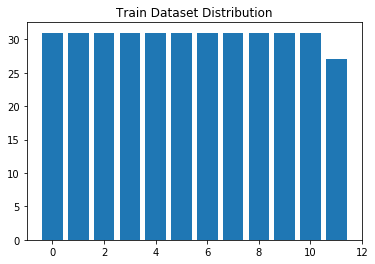

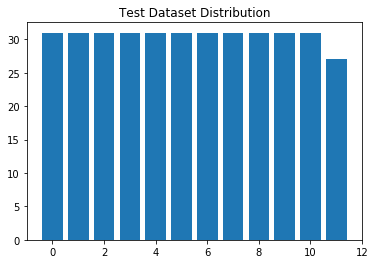

In [16]:
# calculate train dataset size
train_hist = {i:0 for i in range(12)}
test_hist = {i:0 for i in range(12)}
dataset_size = [0., 0.]
for x_batch, y_batch in load_data('train'):
    for i in y_batch:
        train_hist[i] += 1
    dataset_size[0] += 1.
    if dataset_size[0] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[0], end='')
print('\rpre-processing dataset: %d' % dataset_size[0])

for x_batch, y_batch in load_data('test'):
    for i in y_batch:
        test_hist[i] += 1
    dataset_size[1] += 1.
    if dataset_size[1] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[1], end='')
print('\rpre-processing dataset: %d' % dataset_size[1])

plt.bar(list(train_hist.keys()), list(train_hist.values()))
plt.title('Train Dataset Distribution')
plt.show()
plt.bar(list(test_hist.keys()), list(test_hist.values()))
plt.title('Test Dataset Distribution')
plt.show()

In [17]:
def plot_one_batch(network, batch_id=0):
    for X_batch, _ in load_data('train'):
        break

    network.predict(X_batch)

    for i,l in enumerate(network.layers):
        if 'spk_rec_hist' in l.__dict__:
            print("Layer {}: average number of spikes={:.4f}".format(i, l.spk_rec_hist.mean()))
        plot_spikes_in_time(l, batch_id)

Network Summery: I(1x64x64) => C3(64,k3) => P(2) => C3(128,k3) => P(2) => C3(256,k3) => P(2) => D(128) => mean(12)
Layer 1: average number of spikes=0.0943


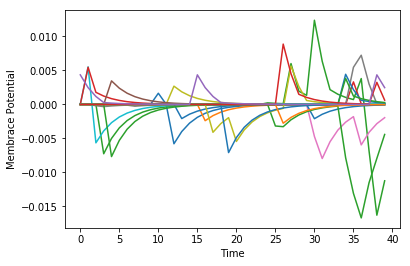

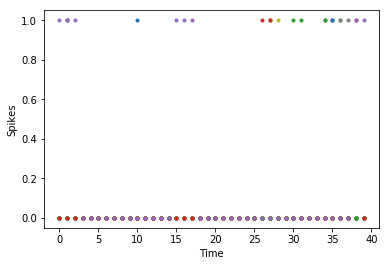

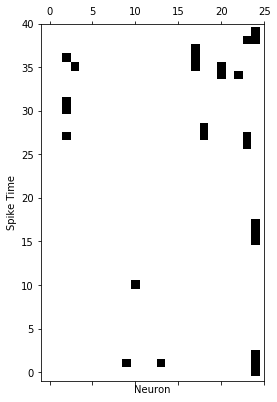

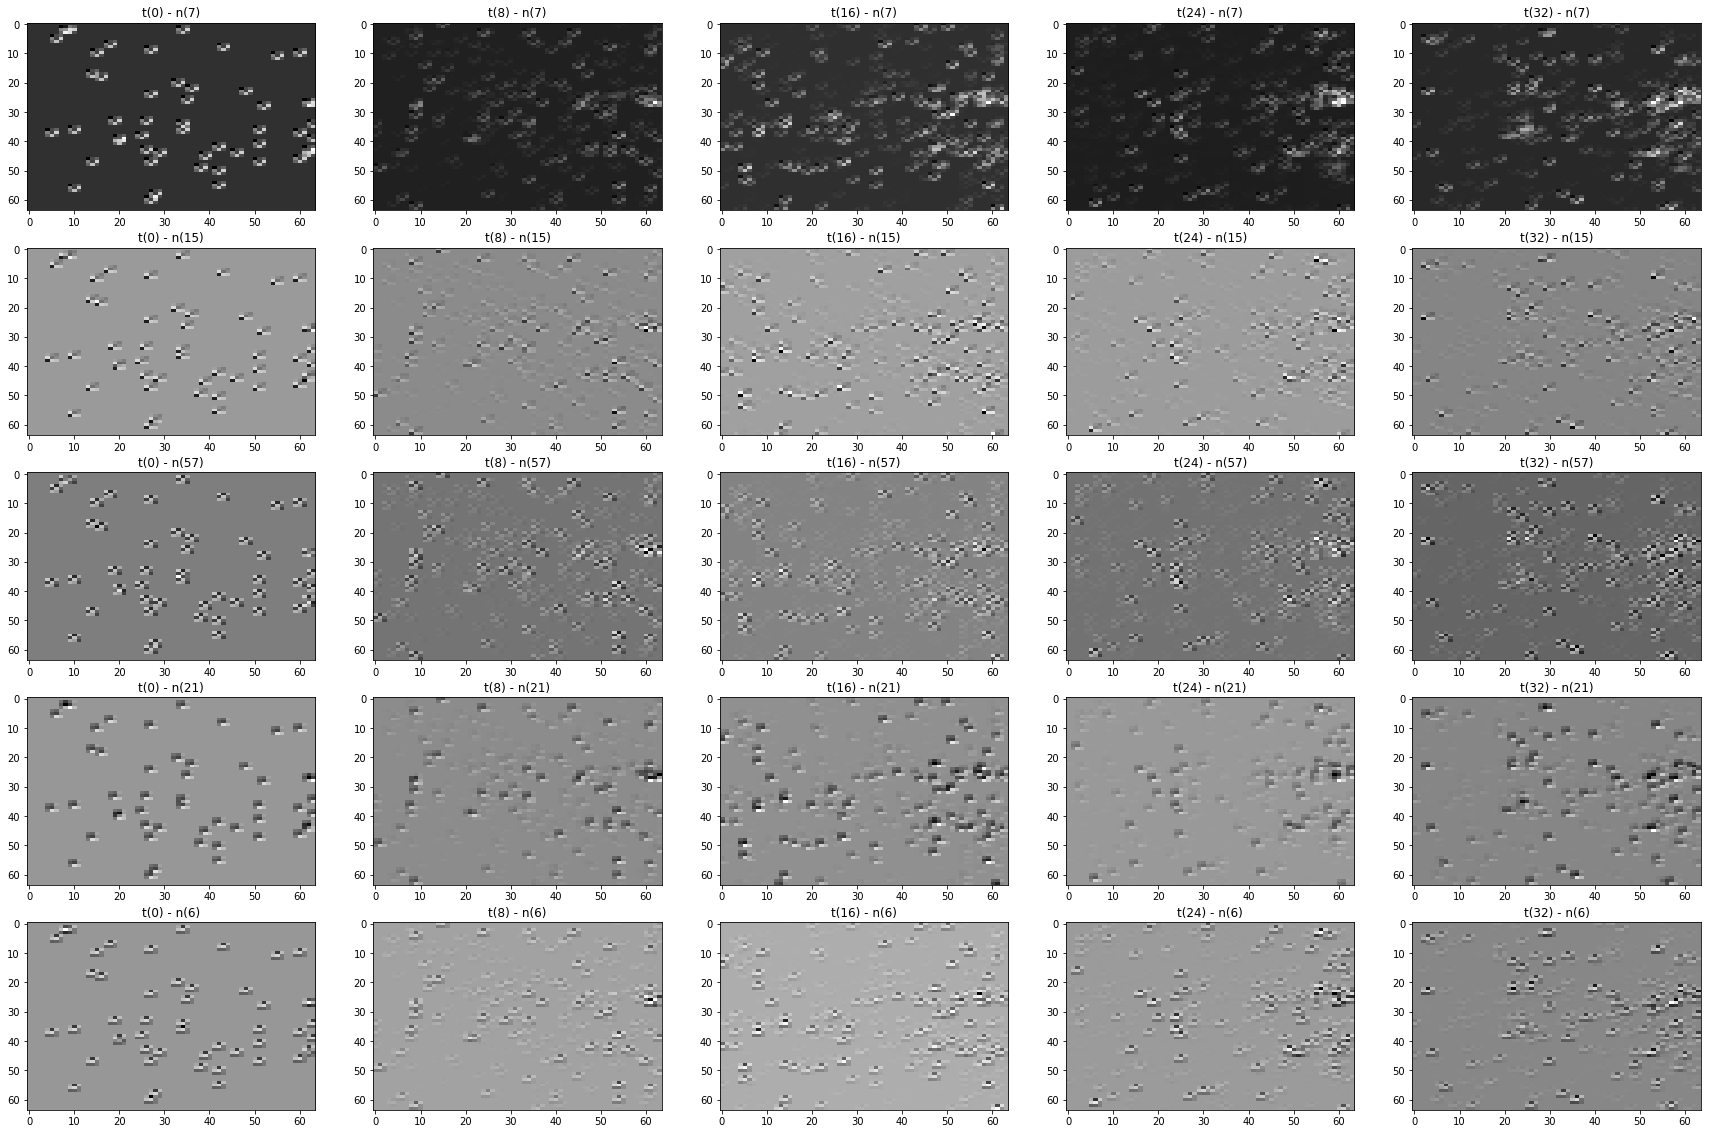

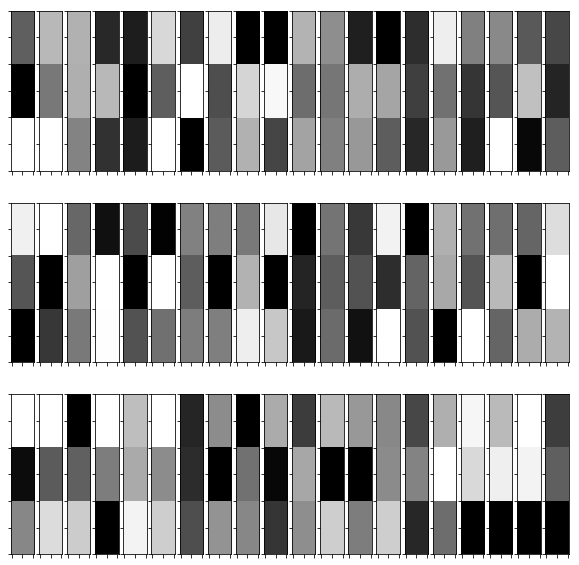

Layer 2: average number of spikes=0.2223
Layer 3: average number of spikes=0.3107


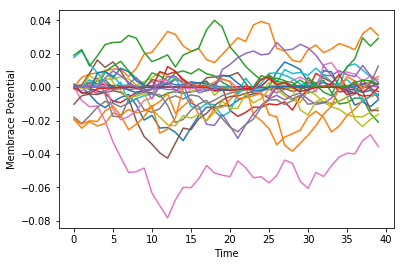

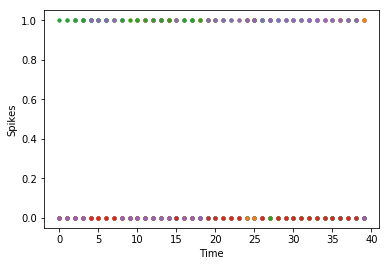

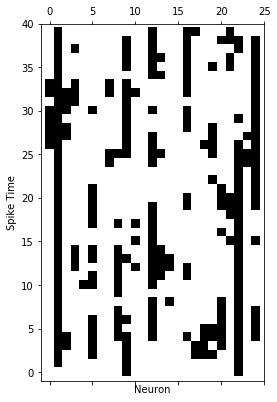

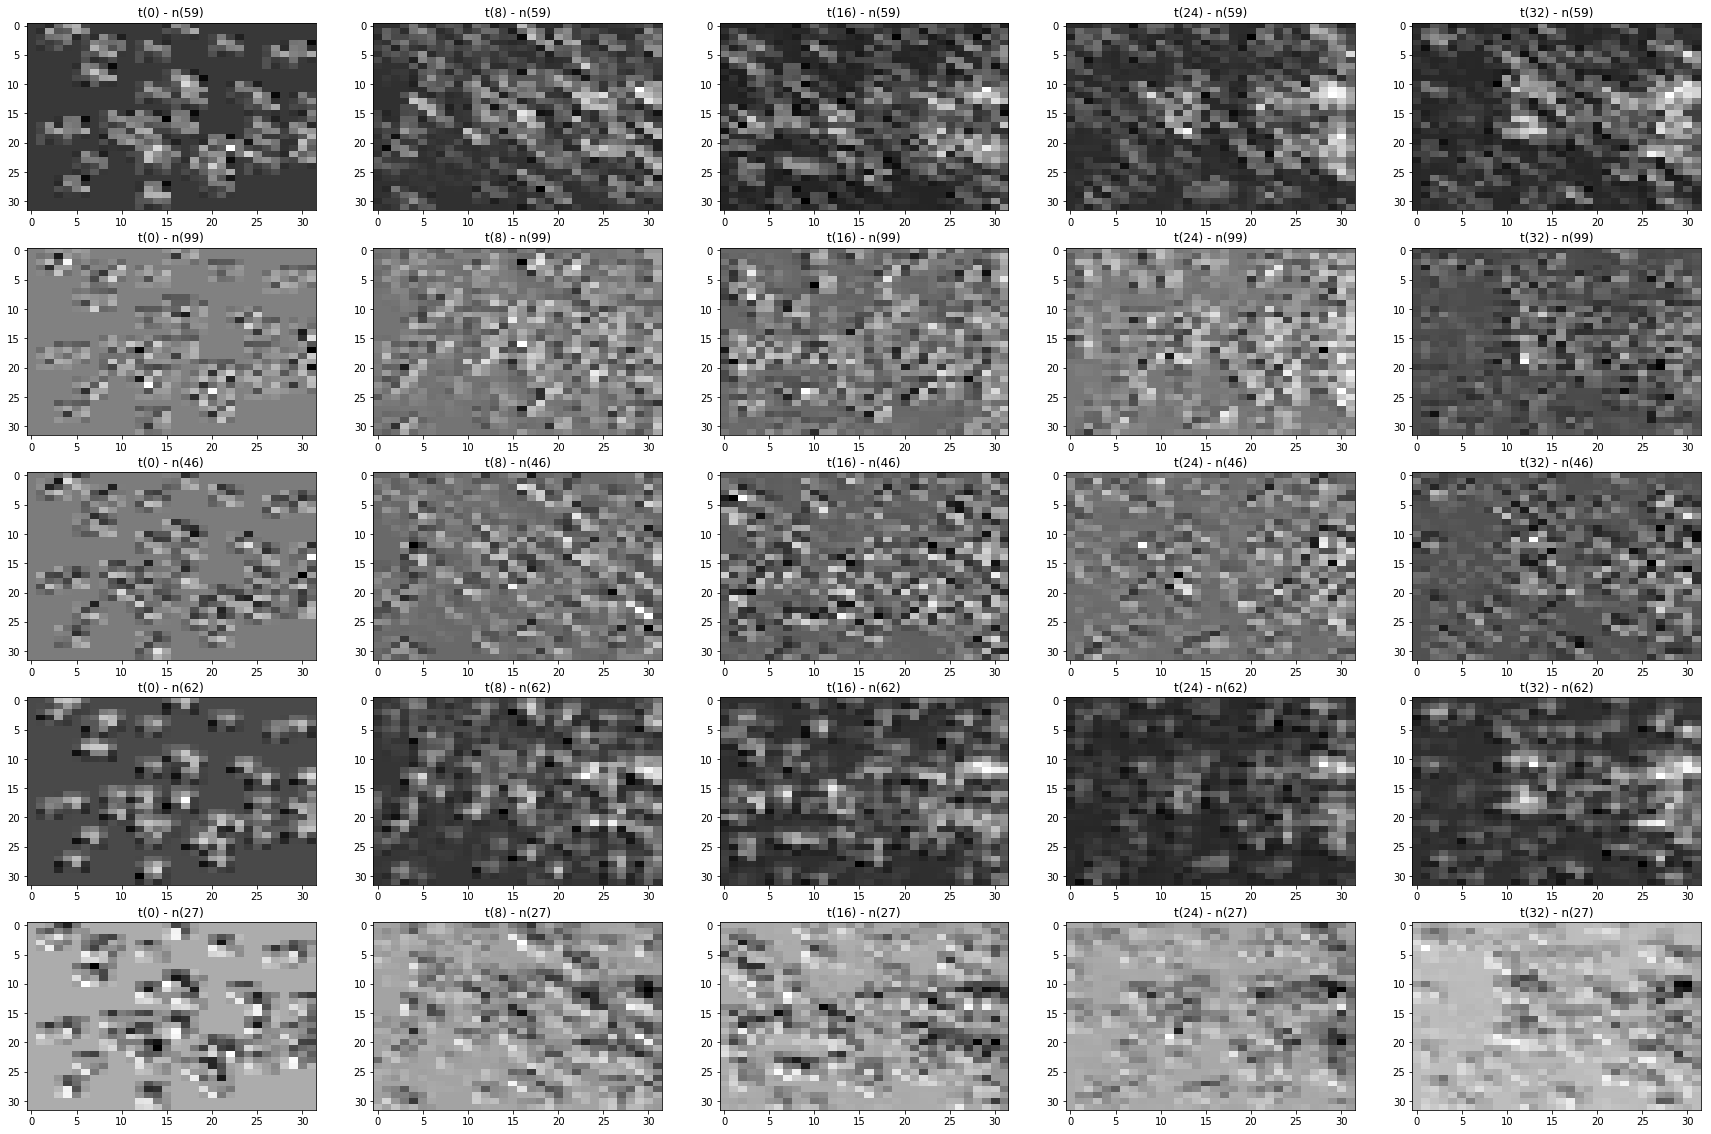

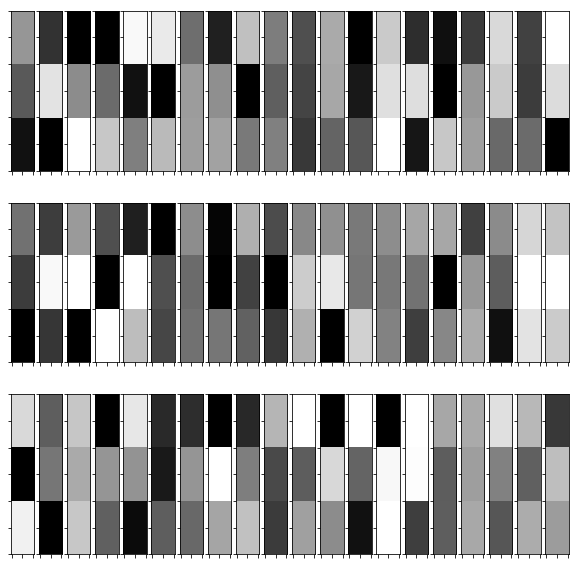

Layer 4: average number of spikes=0.5652
Layer 5: average number of spikes=0.4392


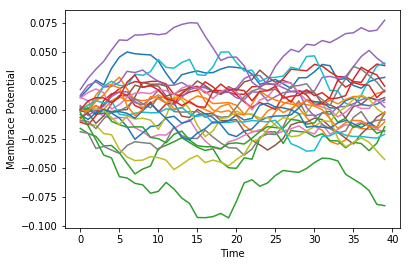

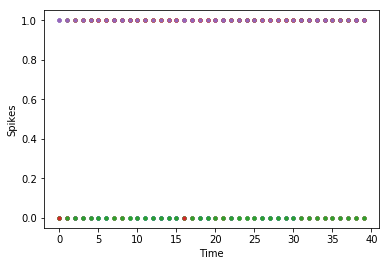

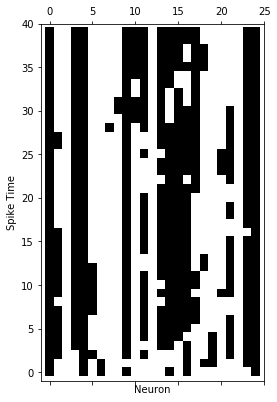

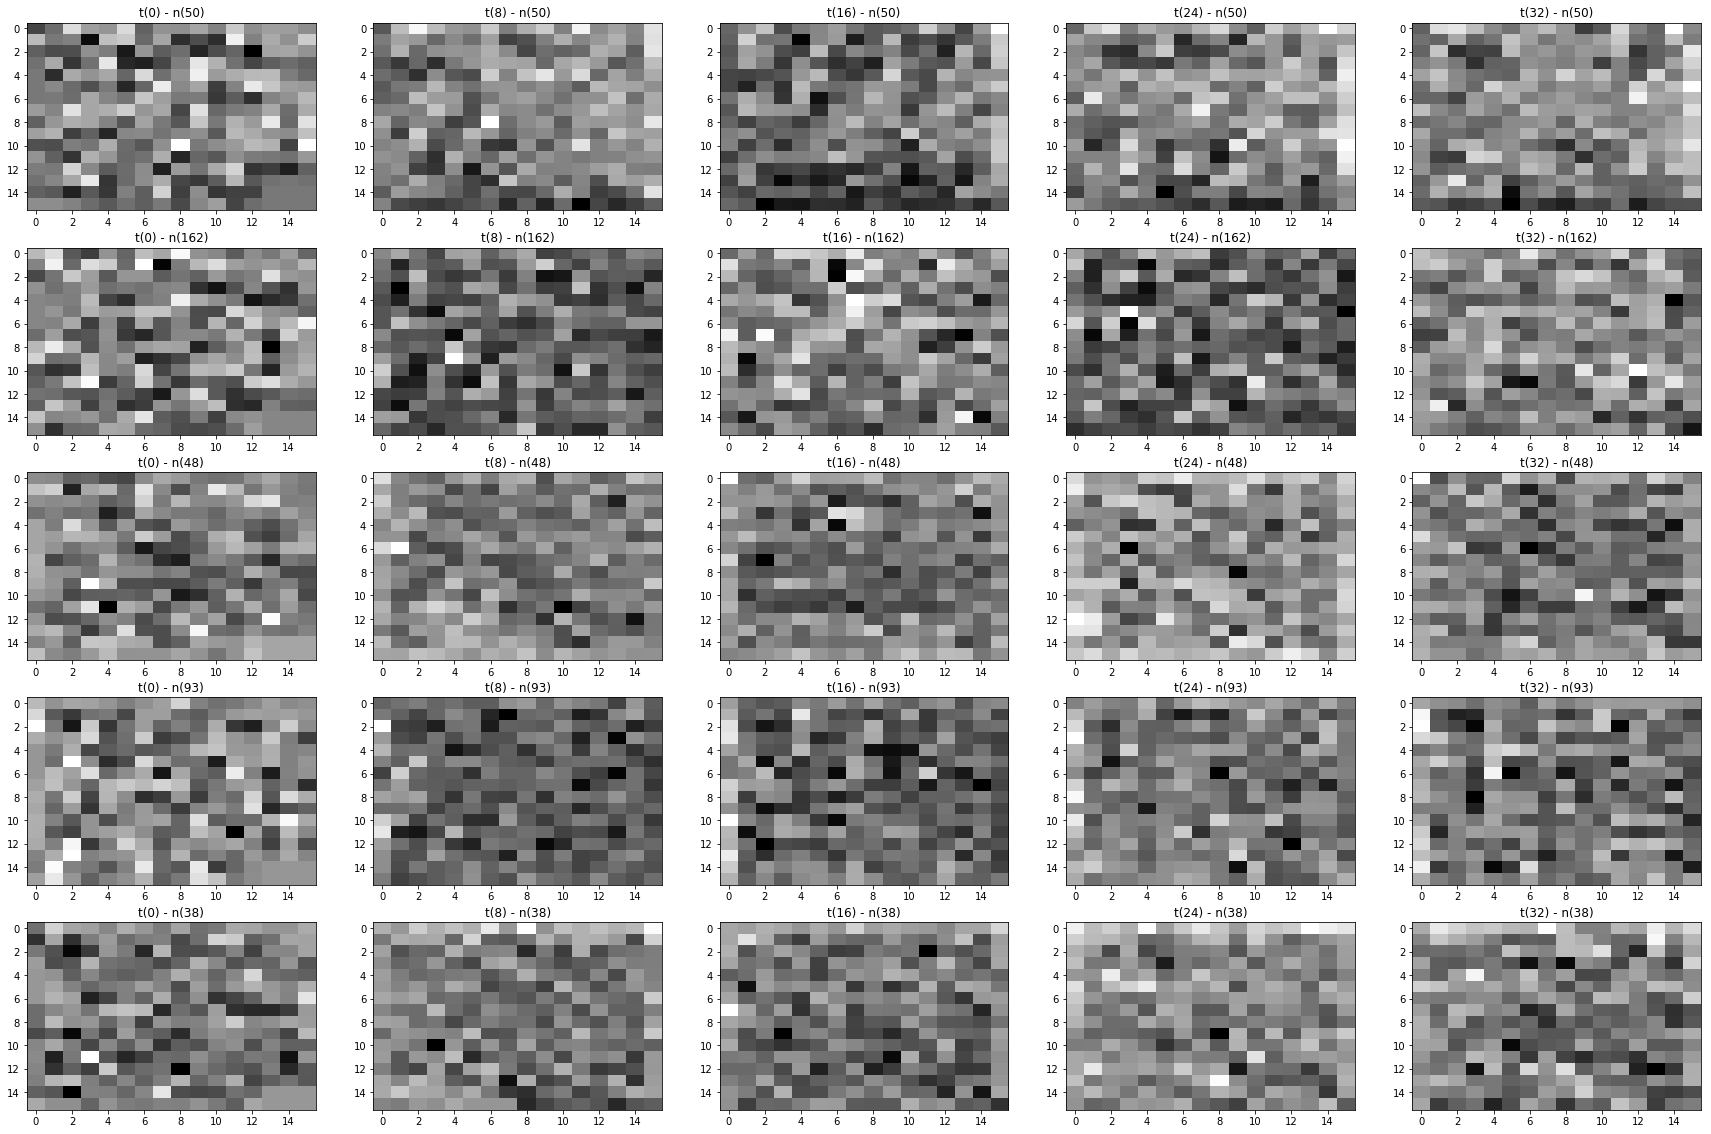

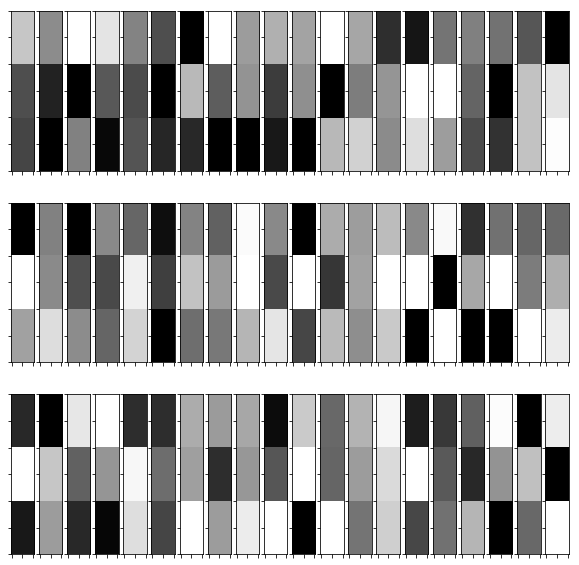

Layer 6: average number of spikes=0.6236
Layer 7: average number of spikes=0.0416


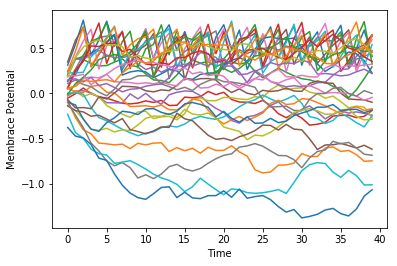

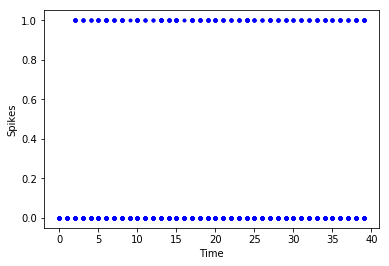

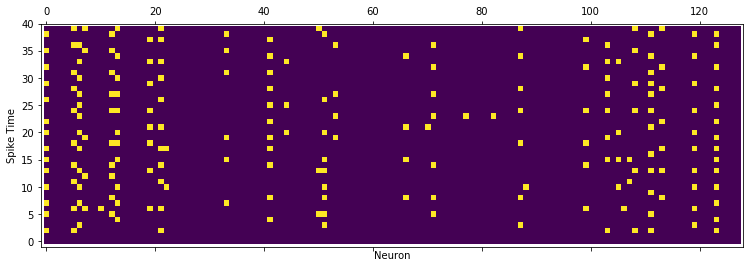

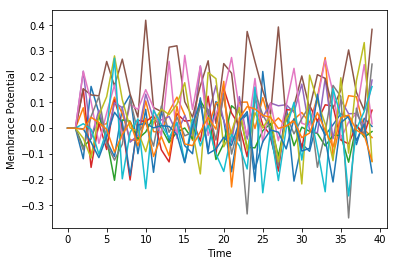

In [18]:
network = SNN(device=device, dtype=dtype)
network.time_expector = time_expector
# network.notifier = notify # FIXME

network.add_conv3d(
    input_shape=(64,64),
    
    output_channels=64,
    kernel_size=(1,3,3),
    dilation=(1,1,1),
    lateral_connections=False,
    recurrent=False,
    
    w_init_mean=0.00,
    w_init_std=0.05
)
network.add_pool2d(kernel_size=(2,2))

network.add_conv3d(    
    output_channels=128,
    kernel_size=(1,3,3),
    dilation=(1,1,1),
    lateral_connections=False,
    recurrent=False,
    
    w_init_mean=0.00,
    w_init_std=0.05
)
network.add_pool2d(kernel_size=(2,2))

network.add_conv3d(    
    output_channels=256,
    kernel_size=(1,3,3),
    dilation=(1,1,1),
    lateral_connections=False,
    recurrent=False,
    
    w_init_mean=0.00,
    w_init_std=0.05
)
network.add_pool2d(kernel_size=(2,2))


network.add_dense(
    output_shape=128,
    w_init_mean=0.0,
    w_init_std=0.8
#     lateral_connections=True
)

network.add_readout(
    output_shape=12,
    time_reduction="mean",

    w_init_mean=0.0,
    w_init_std=0.6
)

network.compile()
network = network.to(network.device, network.dtype) # FIXME: this is a bug, fix it!


print('Network Summery:', network.serialize())
plot_one_batch(network)

Epoch: 1 [===========================================================>] 100%                  took 2 minutes   

| Lss.Trn | Lss.Tst | Acc.Trn | Acc.Tst |
|---------|---------|---------|---------|
|  2.5049 |  2.4817 |   8.42% |   8.42% |

Epoch: 2 [===========================================================>] 100%                  took 2 minutes   

| Lss.Trn | Lss.Tst | Acc.Trn | Acc.Tst |
|---------|---------|---------|---------|
|  2.4825 |  2.4509 |   8.42% |   8.42% |

Epoch: 3 [===========================================================>] 100%                  took 2 minutes   

| Lss.Trn | Lss.Tst | Acc.Trn | Acc.Tst |
|---------|---------|---------|---------|
|  2.4564 |  2.4202 |   8.42% |   8.42% |

Epoch: 4 [===========================================================>] 100%                  took 2 minutes   

| Lss.Trn | Lss.Tst | Acc.Trn | Acc.Tst |
|---------|---------|---------|---------|
|  2.4344 |  2.3825 |  15.49% |  15.49% |

Epoch: 5 [==============================

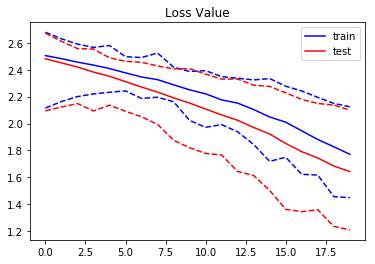

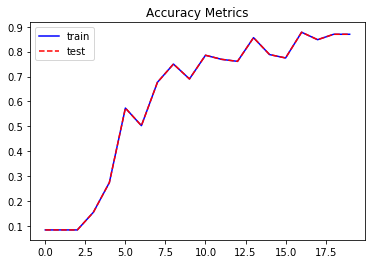

In [19]:
with open('./logs/results.log', 'a+') as f:
    lr=0.00001
    opt = RAdam(network.get_trainable_parameters(lr, 0.0001))
    #     opt = torch.optim.SGD(network.get_trainable_parameters(lr), lr=lr, momentum=0.9)
    res_metrics = network.fit(
        load_data, 
        epochs=nb_epochs,
        optimizer=opt, 
        dataset_size=dataset_size, 
        result_file=f,
        save_checkpoints=True
    )
    plot_metrics(res_metrics, save_plot_path='./logs/metrics_' if SAVE_PLOTS else None)

network.save('./logs/save_network.net')
# network.load('./logs/save_network.net')


Layer 1: average number of spikes=0.0940


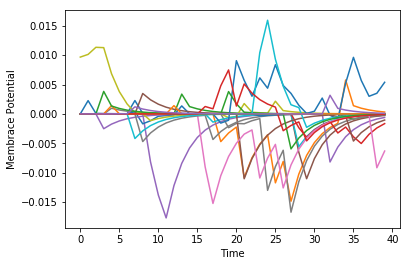

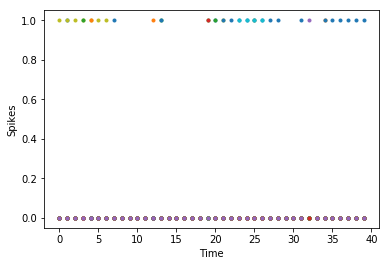

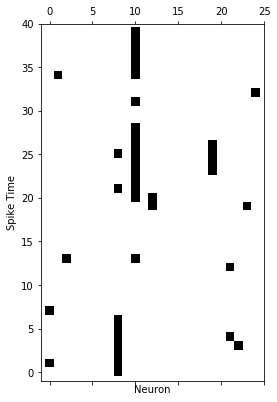

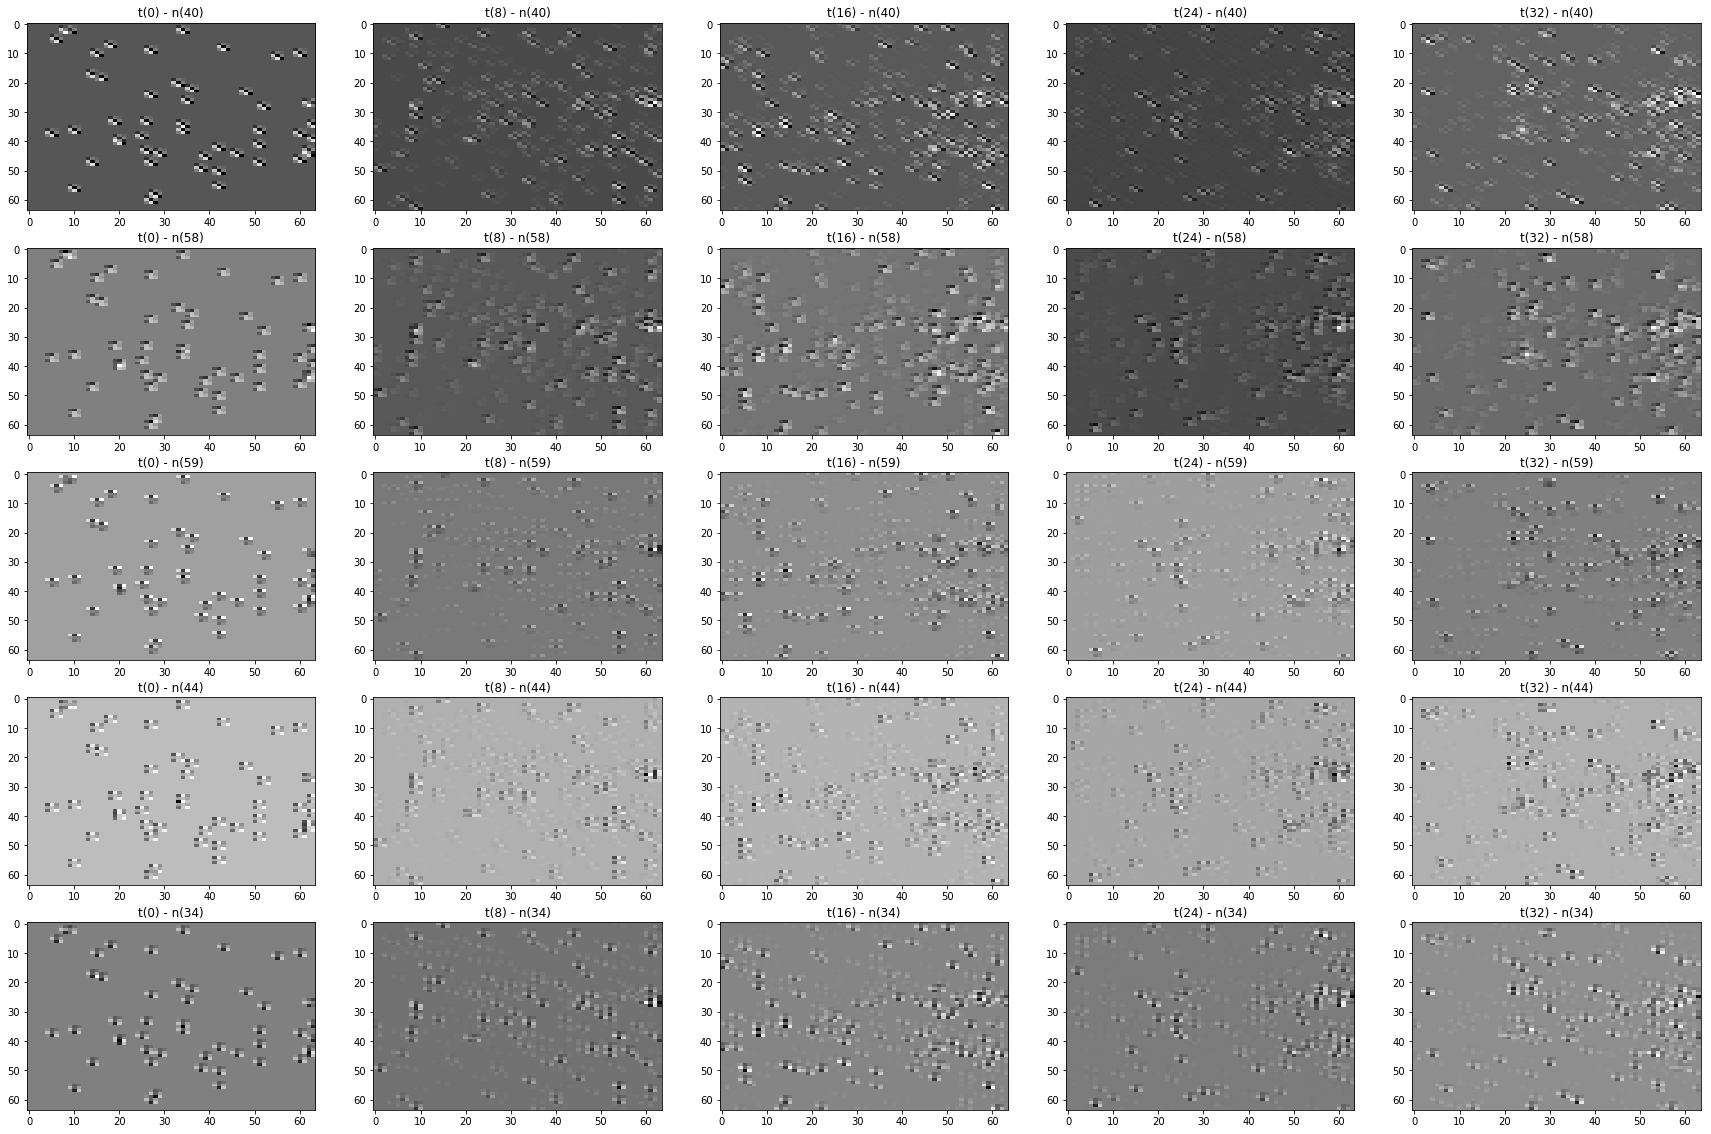

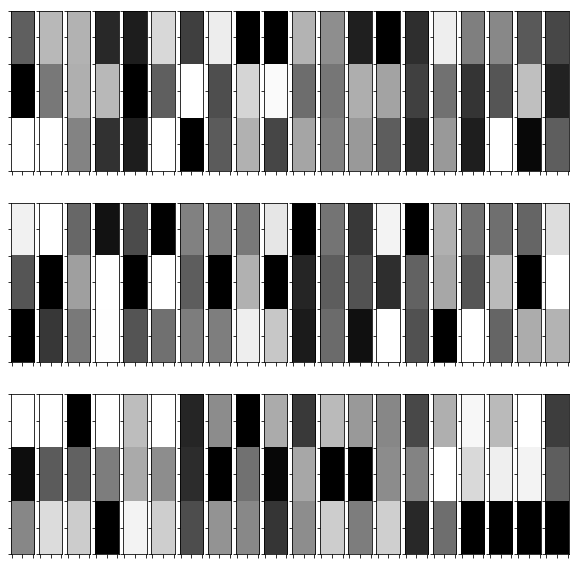

Layer 2: average number of spikes=0.2216
Layer 3: average number of spikes=0.2739


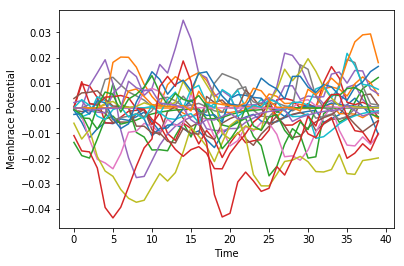

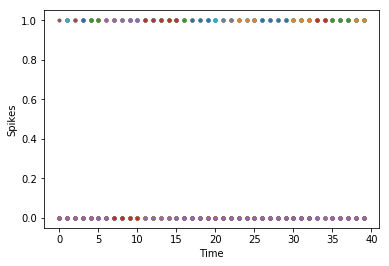

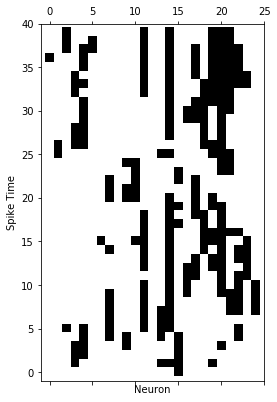

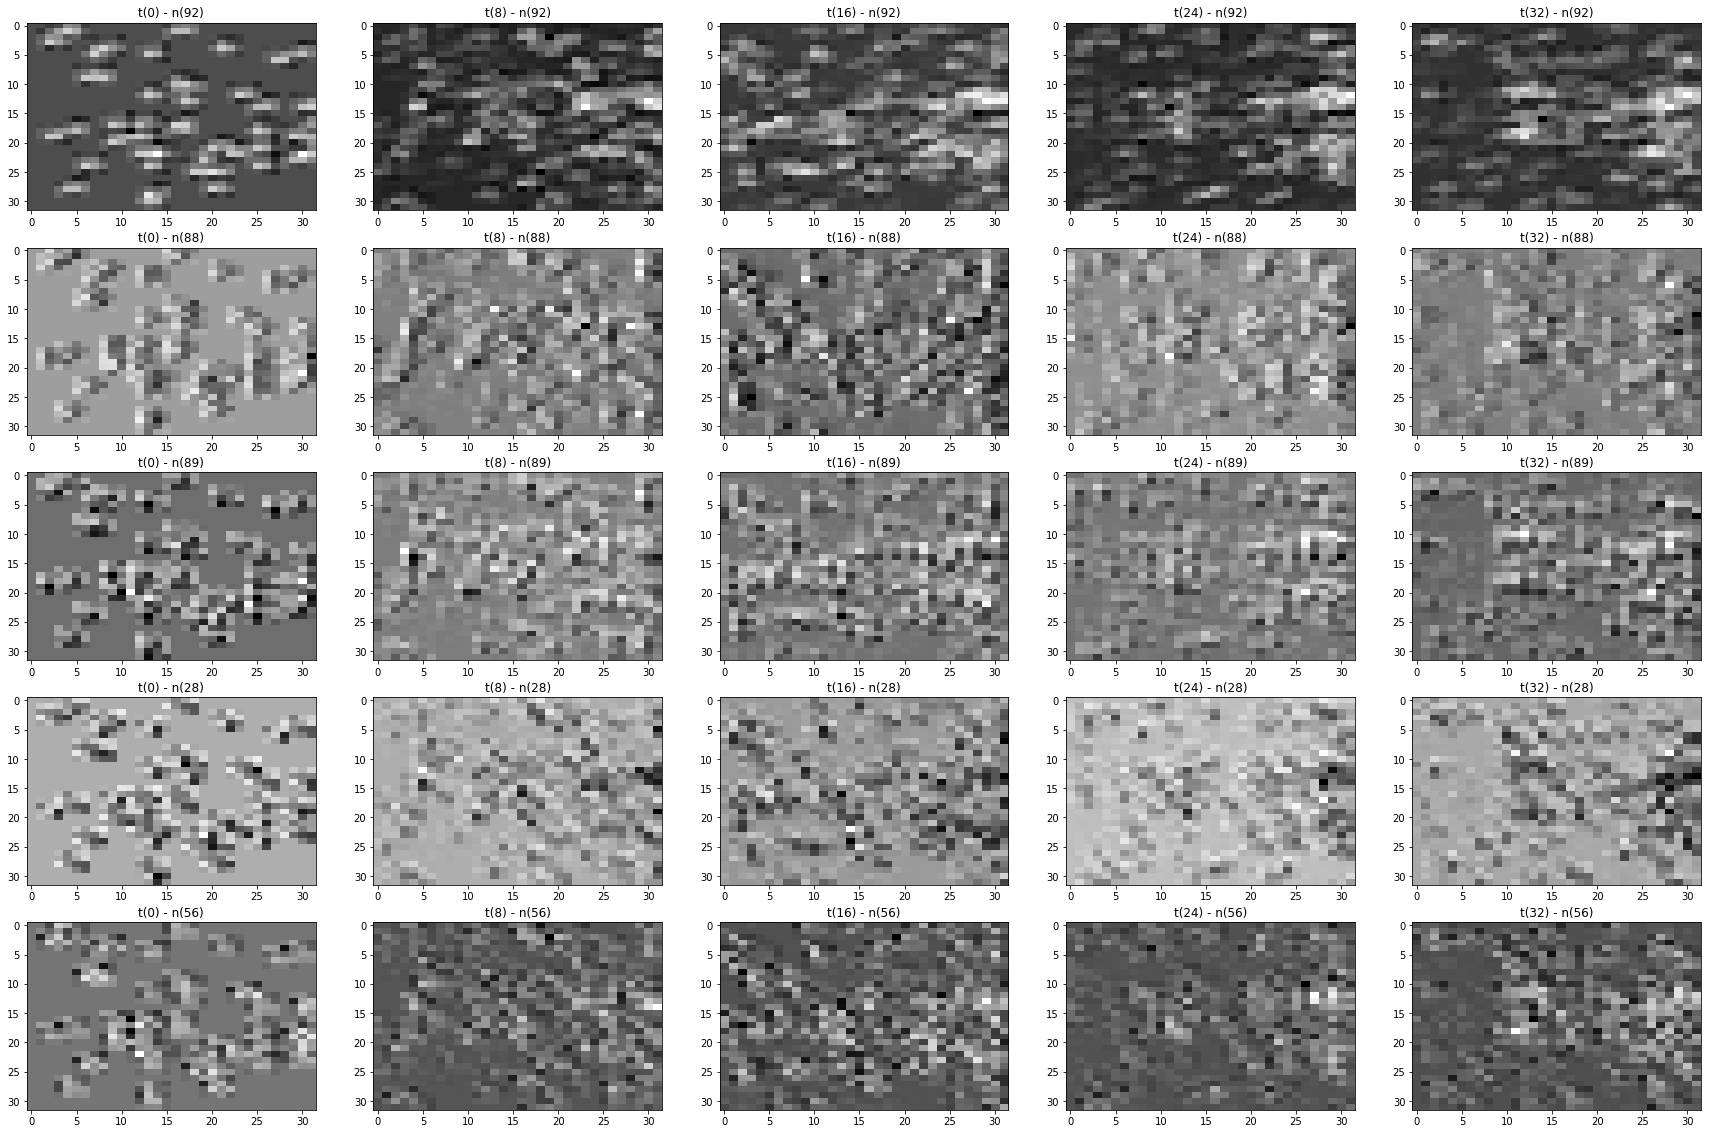

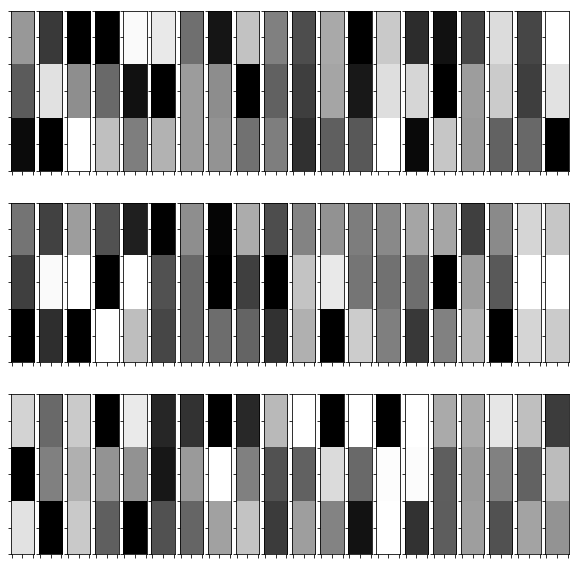

Layer 4: average number of spikes=0.5193
Layer 5: average number of spikes=0.4331


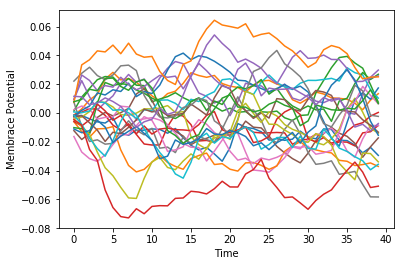

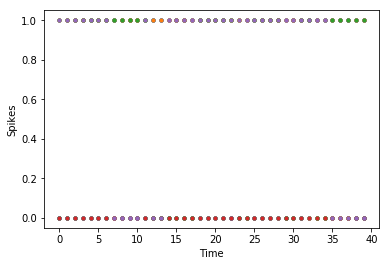

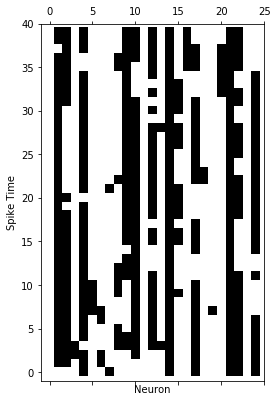

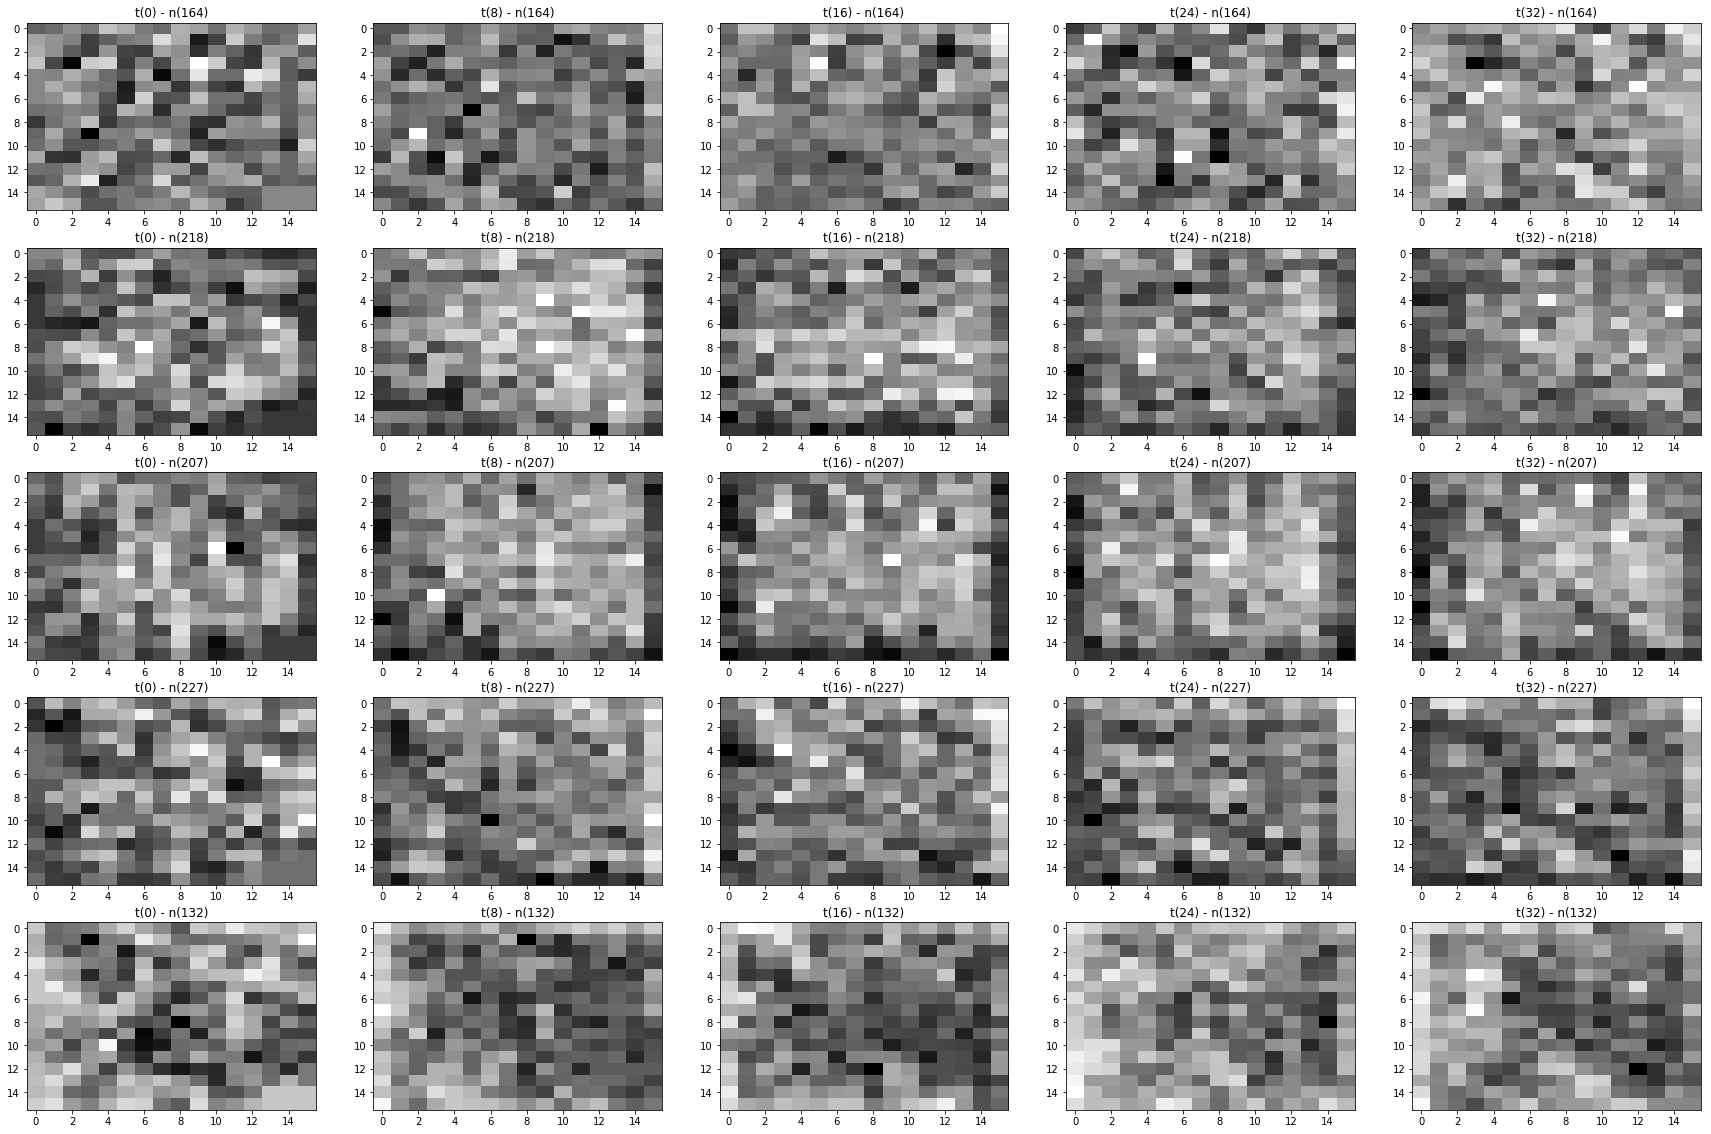

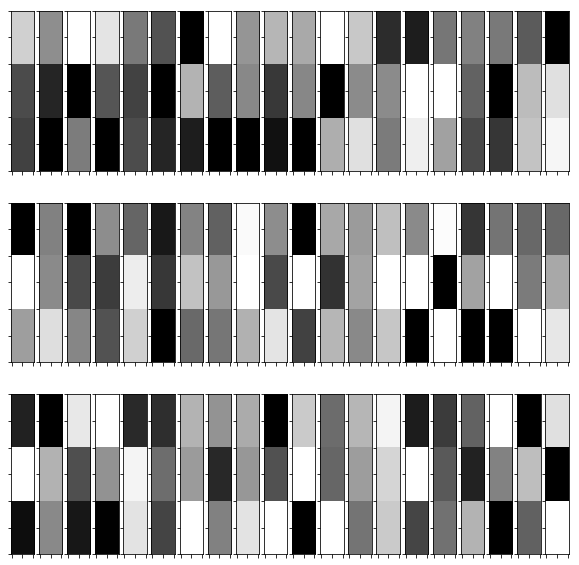

Layer 6: average number of spikes=0.6639
Layer 7: average number of spikes=0.1847


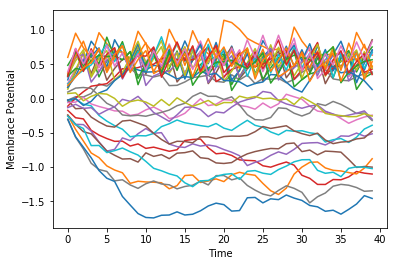

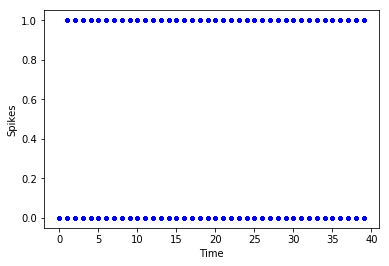

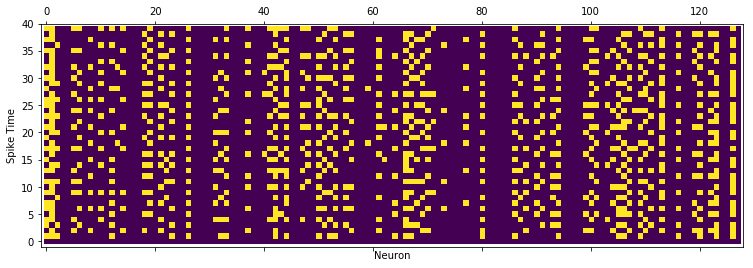

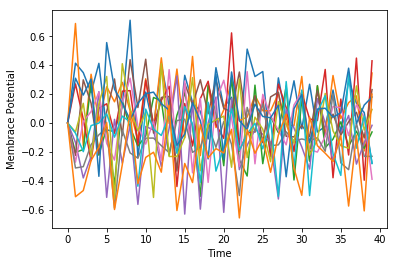


----------------------------------------
Final Train Accuracy=86.96%
Final Test Accuracy=86.96%


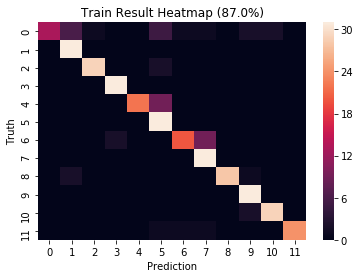

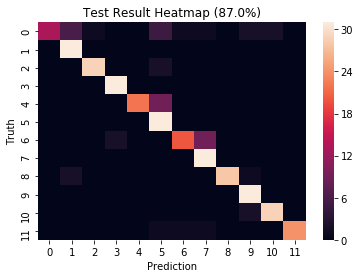

In [20]:
network.load_last_checkpoint()
plot_one_batch(network)
print_and_plot_accuracy_metrics(
    network, 
    load_data('acc_train'), 
    load_data('acc_test'), 
    save_plot_path='./logs/truth_' if SAVE_PLOTS else None
)

In [21]:
# network.predict(X_batch)

# # Plotting spike trains or membrane potential
# for i,l in enumerate(network.layers):
#     if not l.HAS_PARAM or 'spk_rec_hist' not in l.__dict__:
#         continue
        
#     if isinstance(l, SpikingDenseLayer):
#         print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
#         spk_rec = l.spk_rec_hist
#         plot_spk_rec(spk_rec, idx=batch_idx)
#     elif isinstance(l, SpikingConv2DLayer):
#         print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
#         spk_rec = l.spk_rec_hist
#         plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
#     else:
#         mem_rec = l.mem_rec_hist
#         plot_mem_rec(mem_rec, 0)

pre augmentation size:
(700, 40, 64, 64)
(700,)

post augmentation size:
(1524, 40, 64, 64)
(1524,)
pre-processing dataset: 95
pre-processing dataset: 95
Epoch: 1 [===========================================================>] 100%                 took 10 minutes   

| Lss.Trn | Lss.Tst | Acc.Trn | Acc.Tst |
|---------|---------|---------|---------|
|  2.4703 |  2.2550 |  44.08% |  44.08% |

Epoch: 2 [===========================================================>] 100%                 took 10 minutes   

| Lss.Trn | Lss.Tst | Acc.Trn | Acc.Tst |
|---------|---------|---------|---------|
|  2.4002 |  2.2095 |  46.05% |  46.05% |

Epoch: 3 [===========================================================>] 100%                 took 10 minutes   

| Lss.Trn | Lss.Tst | Acc.Trn | Acc.Tst |
|---------|---------|---------|---------|
|  2.3217 |  2.1457 |  52.70% |  52.70% |

Epoch: 4 [===========================================================>] 100%                 took 10 minutes   

| Lss.Trn | L

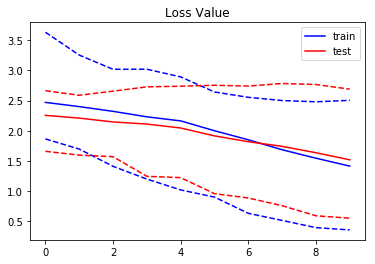

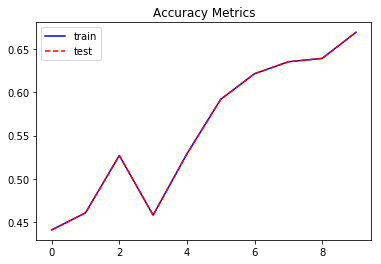

Layer 1: average number of spikes=0.0889


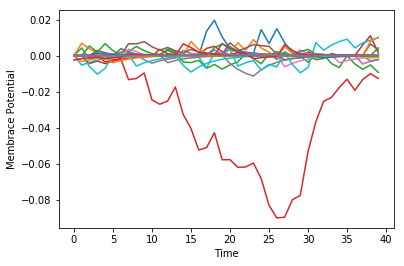

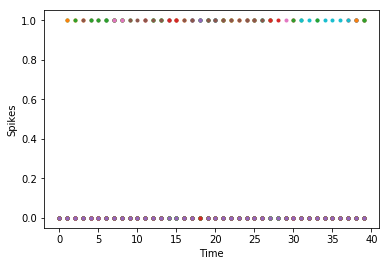

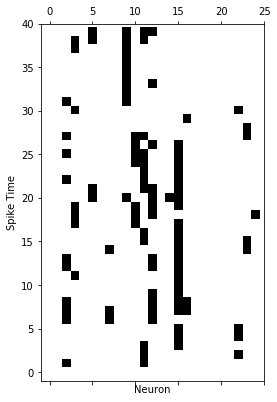

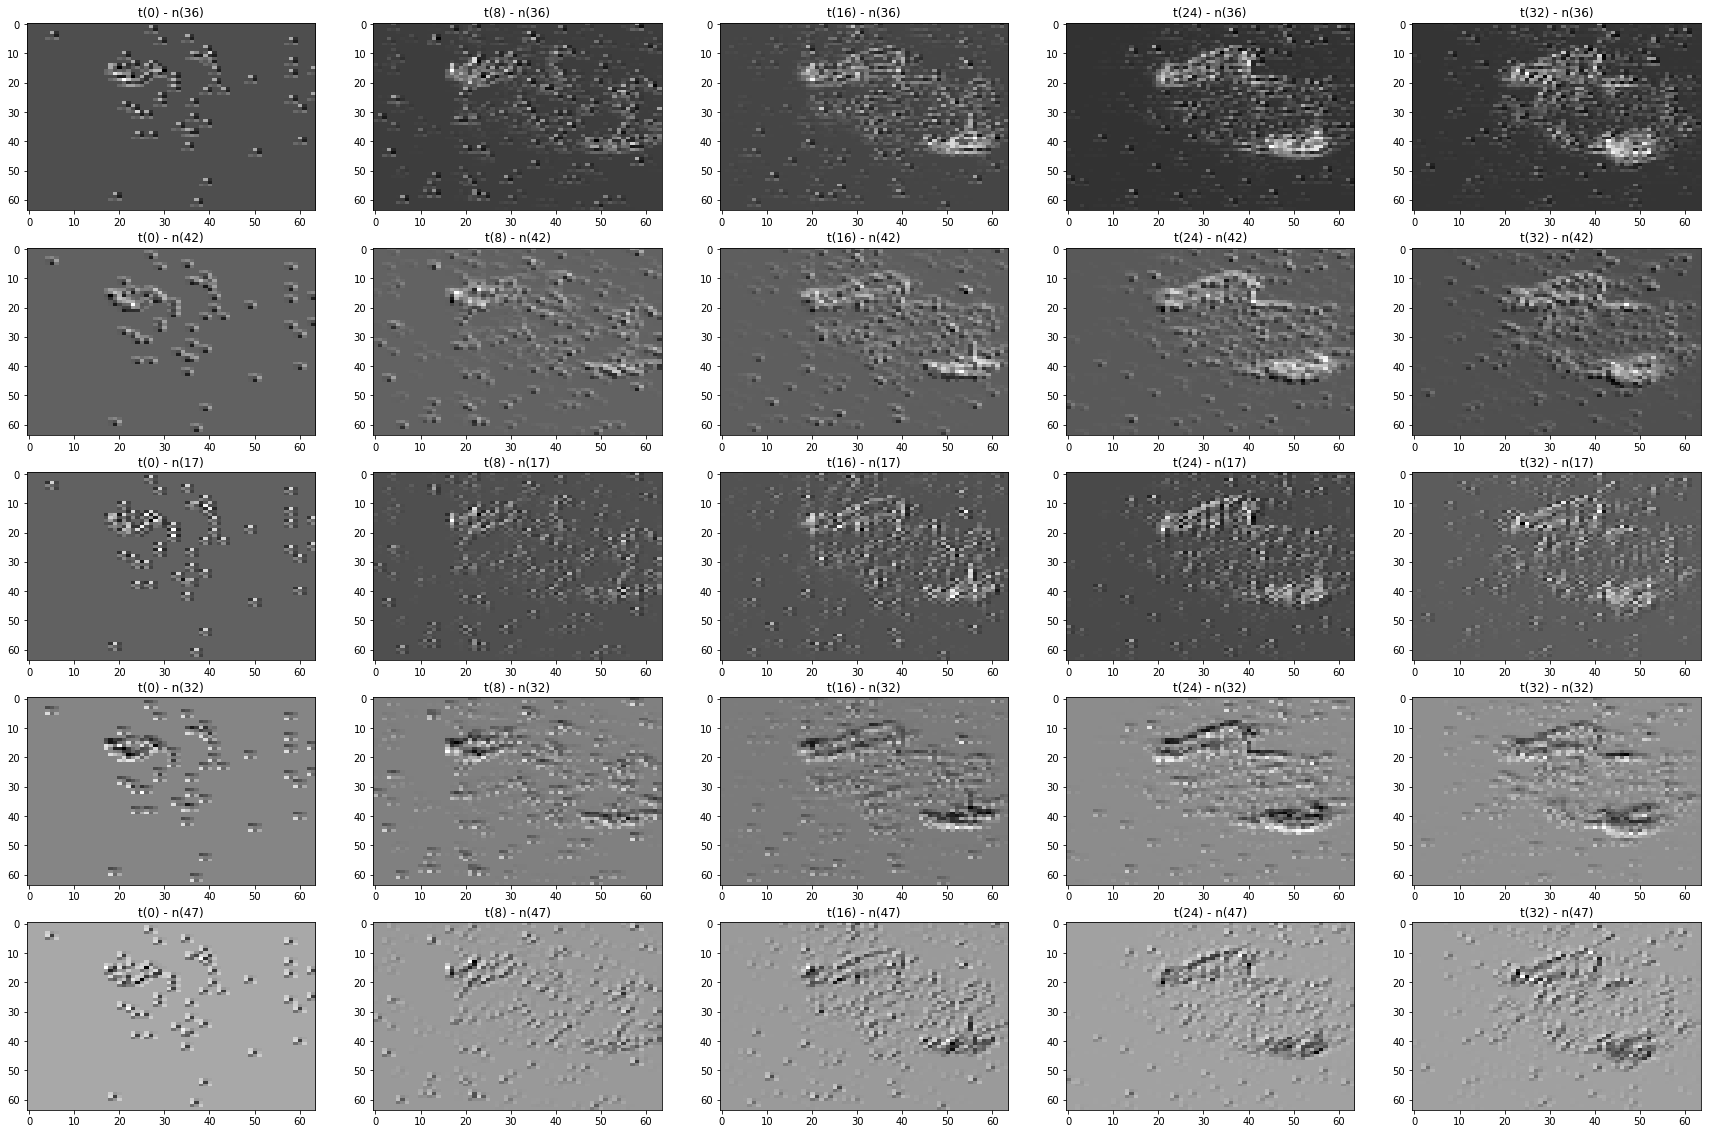

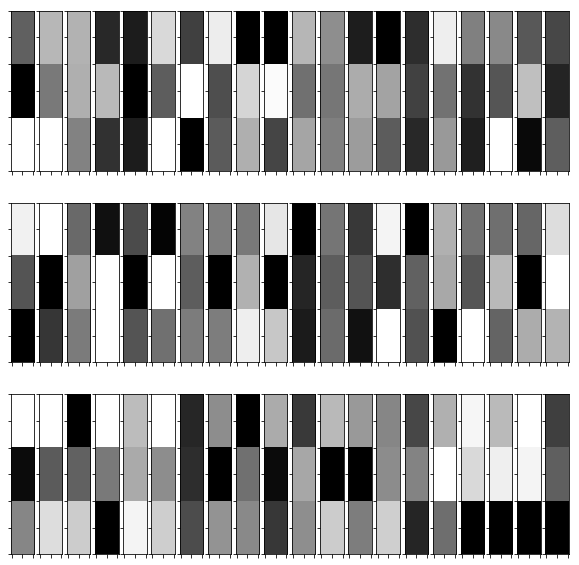

Layer 2: average number of spikes=0.2114
Layer 3: average number of spikes=0.1801


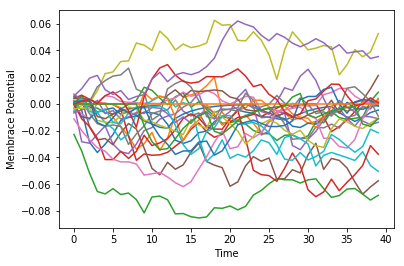

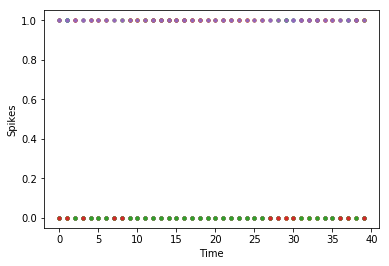

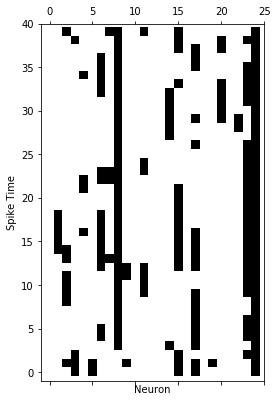

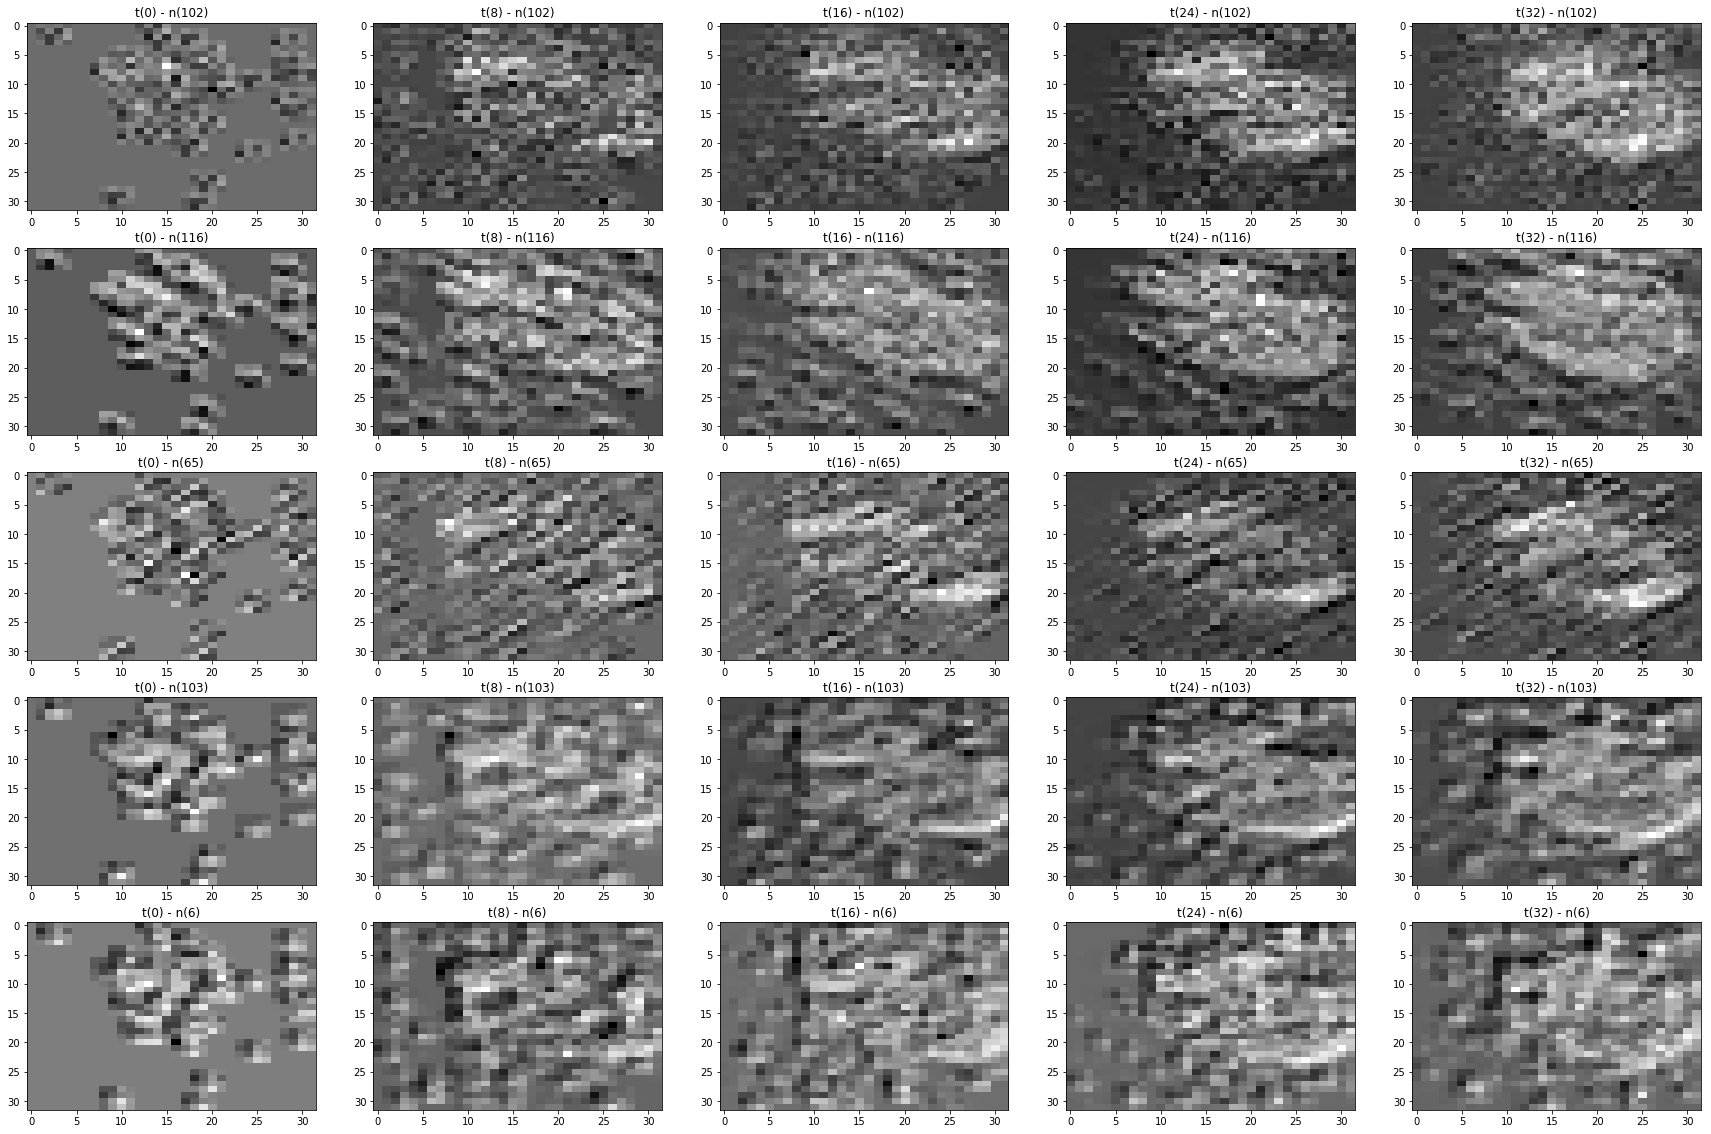

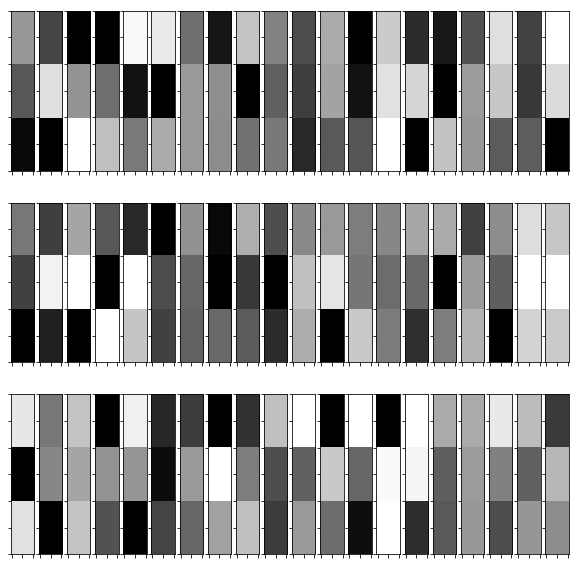

Layer 4: average number of spikes=0.3779
Layer 5: average number of spikes=0.3513


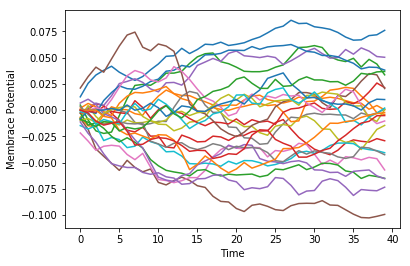

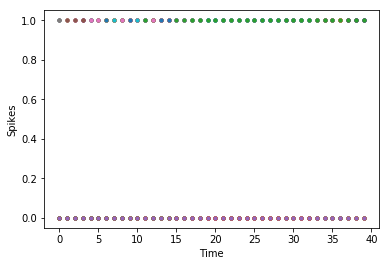

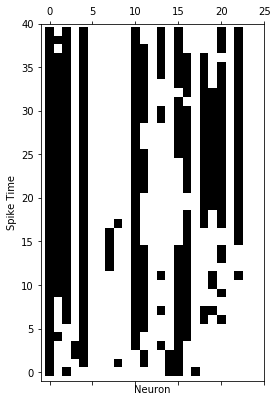

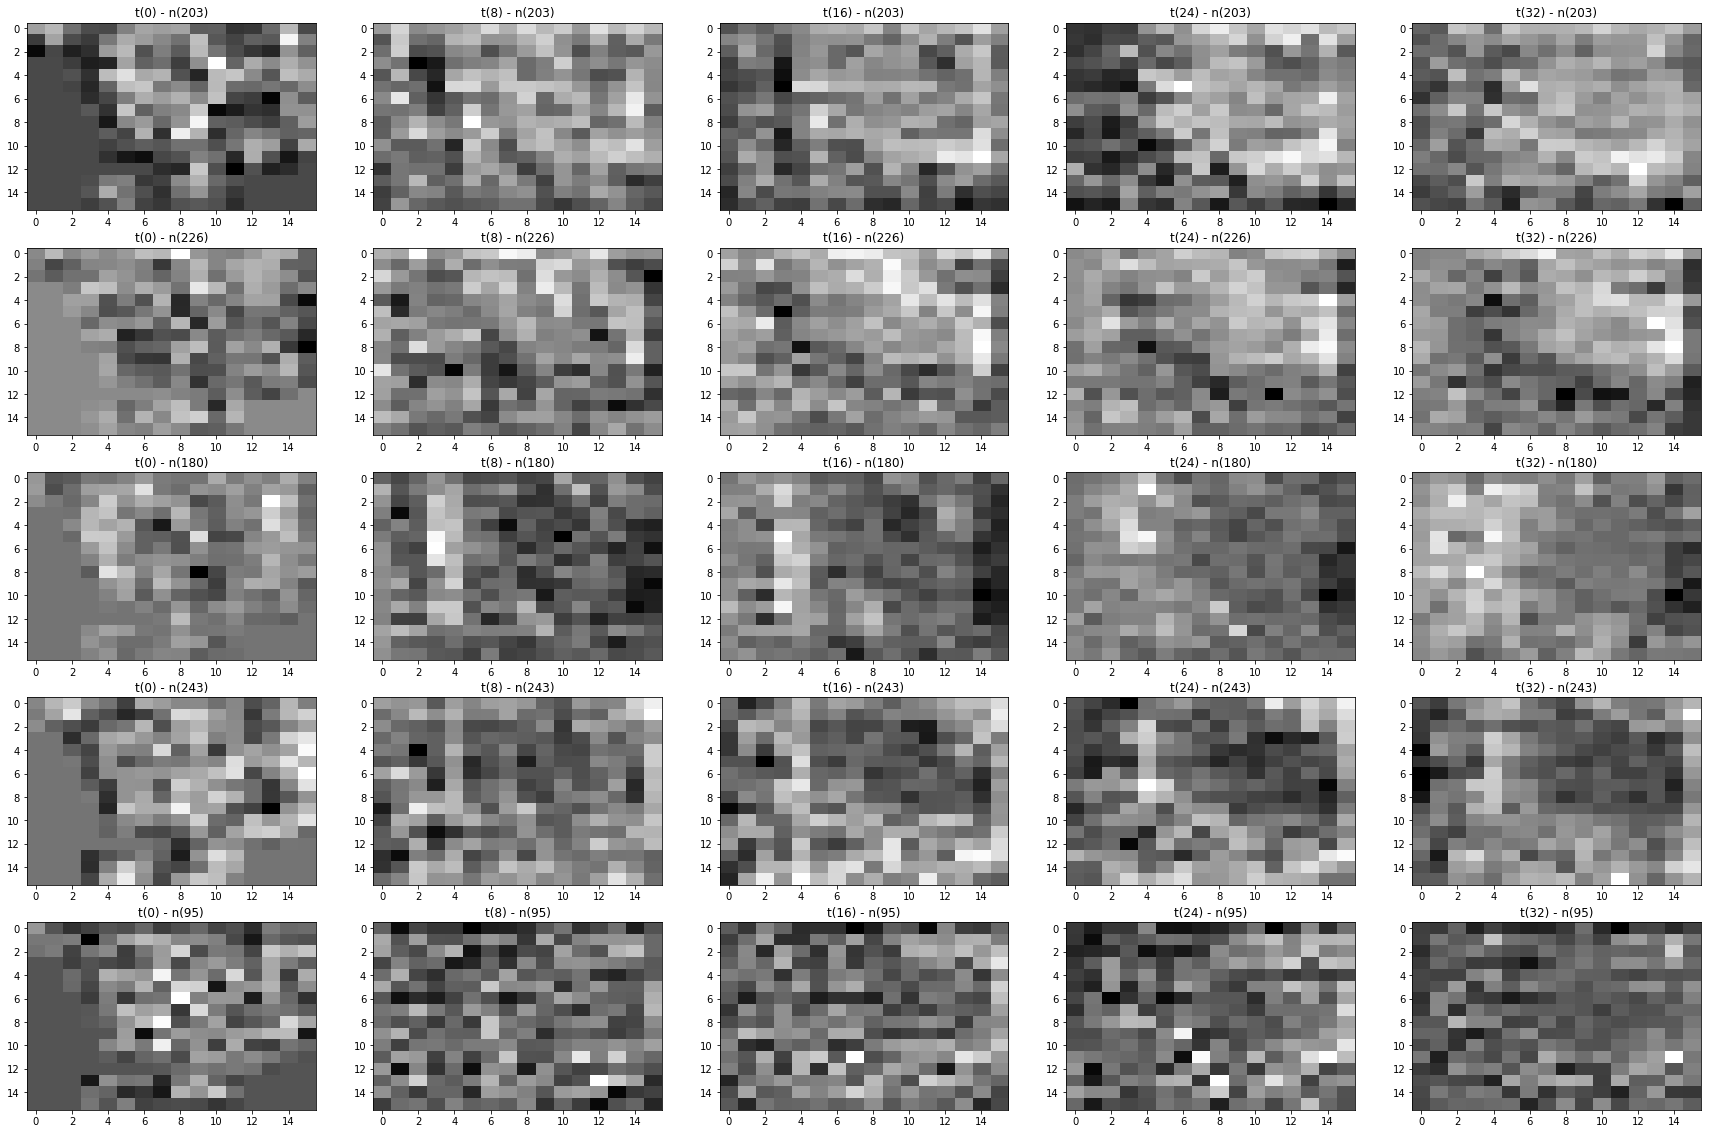

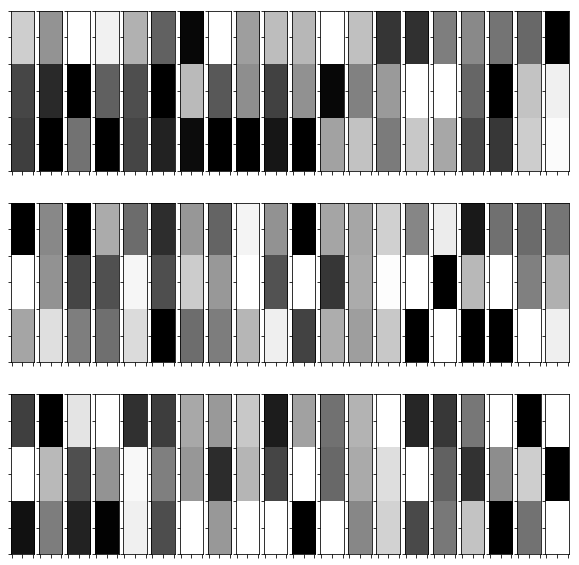

Layer 6: average number of spikes=0.5615
Layer 7: average number of spikes=0.2610


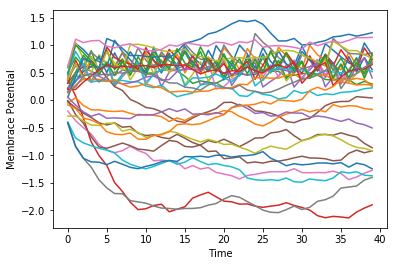

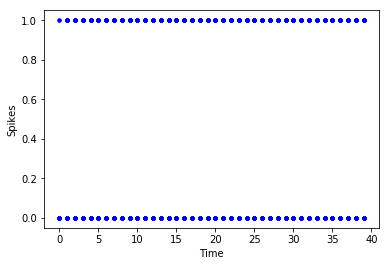

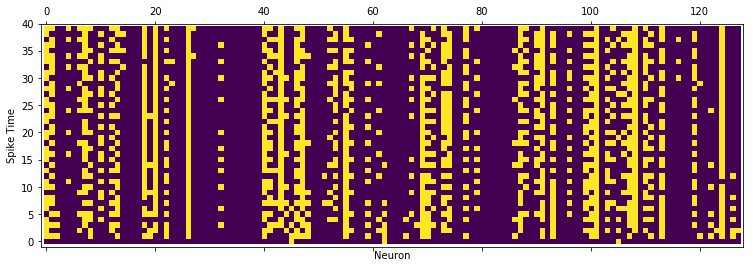

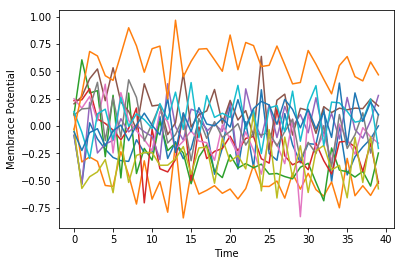


----------------------------------------
Final Train Accuracy=66.97%
Final Test Accuracy=66.97%


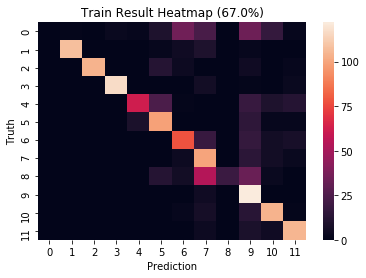

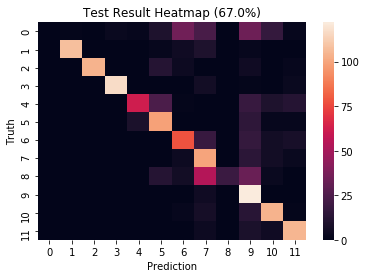

In [ ]:
# Run on larger dataset
original_size = 700
for __xb, __yb in batchify(
    'test',
    DATASET_FOLDER_PATH,
    CACHE_FOLDER_PATH,
    condition_limit=['natural'],
    batch_size=original_size,
    augmentation=False,
    max_augmentation=1,
    frame=nb_frame
):
    break

_hist = {i:0 for i in range(12)}
for i in __yb:
    _hist[i] += 1
max_value = max(_hist.values())

aug_xb = []
aug_yb = []
for i in range(12):
    idx = np.where(__yb == i)[0][0]
    to_add = max_value - _hist[i]
    for _ in range(to_add):
        aug_yb.append(i)
        aug_xb.append(__xb[idx, :, :, :])

print('pre augmentation size:')
print(__xb.shape)
print(__yb.shape)
__yb = np.concatenate([__yb, np.array(aug_yb)])
__xb = np.concatenate([__xb, np.array(aug_xb)])
print('\npost augmentation size:')
print(__xb.shape)
print(__yb.shape)


def load_data(trail):
    begin = 0
    end = begin + batch_size
    while end <= __yb.shape[0]:
        yield __xb[begin:end, :, :, :], __yb[begin:end]
        begin = end
        end = begin + batch_size


# calculate train dataset size
dataset_size = [0., 0.]
for x_batch, y_batch in load_data('train'):
    dataset_size[0] += 1.
    if dataset_size[0] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[0], end='')
print('\rpre-processing dataset: %d' % dataset_size[0])

for x_batch, y_batch in load_data('test'):
    dataset_size[1] += 1.
    if dataset_size[1] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[1], end='')
print('\rpre-processing dataset: %d' % dataset_size[1])

network.load_last_checkpoint()
with open('./logs/results.log', 'a+') as f:
    lr=0.00001
    opt = RAdam(network.get_trainable_parameters(lr, 0.00001))
#     opt = torch.optim.SGD(network.get_trainable_parameters(lr), lr=lr, momentum=0.9)
    res_metrics = network.fit(
        load_data, 
        epochs=10,
        optimizer=opt, 
        dataset_size=dataset_size, 
        result_file=f,
        save_checkpoints=True
    )
    plot_metrics(res_metrics, save_plot_path='./logs/metrics_B_' if SAVE_PLOTS else None)


plot_one_batch(network)
print_and_plot_accuracy_metrics(
    network, 
    load_data('acc_train'), 
    load_data('acc_test'), 
    save_plot_path='./logs/accuracy_B_' if SAVE_PLOTS else None
)

In [ ]:

# Run on full dataset

def load_data(trail):
    if trail.startswith('acc'):
        max_augmentation = 1
        augmentation = False
    else:
        max_augmentation = 2 if trail == 'train' else 1
        augmentation = True
    
    trail = trail.replace('acc_', '')
    return batchify(
        trail,
        DATASET_FOLDER_PATH,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=batch_size,
        augmentation=augmentation,
        max_augmentation=max_augmentation,
        frame=nb_frame
    )

dataset_size = [0., 0.]
for x_batch, y_batch in load_data('train'):
    dataset_size[0] += 1.
    if dataset_size[0] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[0], end='')
print('\rpre-processing dataset: %d' % dataset_size[0])

for x_batch, y_batch in load_data('test'):
    dataset_size[1] += 1.
    if dataset_size[1] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[1], end='')
print('\rpre-processing dataset: %d' % dataset_size[1])

network.load_last_checkpoint()
with open('./logs/results.log', 'a+') as f:
    lr=0.00001
    opt = RAdam(network.get_trainable_parameters(lr, 0.00001))
#     opt = torch.optim.SGD(network.get_trainable_parameters(lr), lr=lr, momentum=0.9)
    res_metrics = network.fit(
        load_data, 
        epochs=3,
        optimizer=opt, 
        dataset_size=dataset_size, 
        result_file=f,
        save_checkpoints=True
    )
    plot_metrics(res_metrics, save_plot_path='./logs/metrics_C_' if SAVE_PLOTS else None)

network.save('./logs/save_network.net')


plot_one_batch(network)
print_and_plot_accuracy_metrics(
    network, 
    load_data('acc_train'), 
    load_data('acc_test'), 
    save_plot_path='./logs/accuracy_C_' if SAVE_PLOTS else None
)

pre-processing dataset: 1950
pre-processing dataset: 171
Epoch: 1 [--------------------->......................................]  35%               7 hours remaining   

In [ ]:

# Run on full dataset

def load_data(trail):
    if trail.startswith('acc'):
        max_augmentation = 1
        augmentation = False
    else:
        max_augmentation = 2 if trail == 'train' else 1
        augmentation = True
    
    trail = trail.replace('acc_', '')
    return batchify(
        trail,
        DATASET_FOLDER_PATH,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=batch_size,
        augmentation=augmentation,
        max_augmentation=max_augmentation,
        frame=nb_frame
    )

dataset_size = [0., 0.]
for x_batch, y_batch in load_data('train'):
    dataset_size[0] += 1.
    if dataset_size[0] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[0], end='')
print('\rpre-processing dataset: %d' % dataset_size[0])

for x_batch, y_batch in load_data('test'):
    dataset_size[1] += 1.
    if dataset_size[1] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[1], end='')
print('\rpre-processing dataset: %d' % dataset_size[1])

network.load_last_checkpoint()
with open('./logs/results.log', 'a+') as f:
    lr=0.00001
    opt = RAdam(network.get_trainable_parameters(lr, 0.00001))
#     opt = torch.optim.SGD(network.get_trainable_parameters(lr), lr=lr, momentum=0.9)
    res_metrics = network.fit(
        load_data, 
        epochs=10,
        optimizer=opt, 
        dataset_size=dataset_size, 
        result_file=f,
        save_checkpoints=True
    )
    plot_metrics(res_metrics, save_plot_path='./logs/metrics_C_' if SAVE_PLOTS else None)

network.save('./logs/save_network.net')


plot_one_batch(network)
print_and_plot_accuracy_metrics(
    network, 
    load_data('acc_train'), 
    load_data('acc_test'), 
    save_plot_path='./logs/accuracy_C_' if SAVE_PLOTS else None
)

In [ ]:

# Run on full dataset

network.load_last_checkpoint()
plot_one_batch(network, 2)
# print_and_plot_accuracy_metrics(
#     network, 
#     load_data('acc_train'), 
#     load_data('acc_test'), 
#     save_plot_path='./logs/accuracy_C_' if SAVE_PLOTS else None
# )

In [ ]:

# Run on full dataset

network.load_last_checkpoint()
plot_one_batch(network, 3)
# print_and_plot_accuracy_metrics(
#     network, 
#     load_data('acc_train'), 
#     load_data('acc_test'), 
#     save_plot_path='./logs/accuracy_C_' if SAVE_PLOTS else None
# )